## When for path finding intermediate goal are to found by matching the conflicting RoadElement with nearby Referenced Lines 
These Referened Lines can be of any type and not limited to *Probe Lines*, *Osm Map Data*, *Noisy observation available in the area*, *Goverment Sources*, or any other Reference Data

This example answers on how to correct existing road element using available reference data

NOTE - For example below OSM Map Data is used as reference for solving the conflict

In [1]:
import os
import sys
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd

%matplotlib inline
plt.rcParams['figure.figsize'] = [8, 10]
plt.rcParams['figure.dpi'] = 100

module_path = os.path.abspath(os.path.join('../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from kaizen_mapping.utils.gis import read_data_frame
from kaizen_mapping.map.trace import traces_from_data_frame
from kaizen_mapping.map.grid import PixelGrid
from kaizen_mapping.utils.gis import convert_and_get_extent
from kaizen_mapping.map.navigator import AStar
from shapely.geometry import LineString
from kaizen_mapping.map.matcher import Match
from kaizen_mapping.map.road import road_network_from_data_frame
from kaizen_mapping.map.trace import traces_from_data_frame, single_trace

### Read trace Data Frame

In [2]:
trace_data_frame = read_data_frame(r"D:\Cypherics\Library\kaizen\data\complex_1.shp")

### Read Obstacle Data Frame

In [3]:
obstacle_data_frame = read_data_frame("D:\Cypherics\Library\kaizen\data\complex_1_bfp.shp")

### Read Reference Data Frame
Required Param = ['u', 'v'] (*start node* and *end node* of a edge)

In [4]:
referenced_data_frame = read_data_frame(r"D:\Cypherics\Library\kaizen\data\please_work_osm_complex_1.shp")
referenced_data_frame.columns

Index(['osmid', 'ref', 'name', 'highway', 'oneway', 'length', 'u', 'v', 'key',
       'fid', 'geometry'],
      dtype='object')

### Visualize the data frames

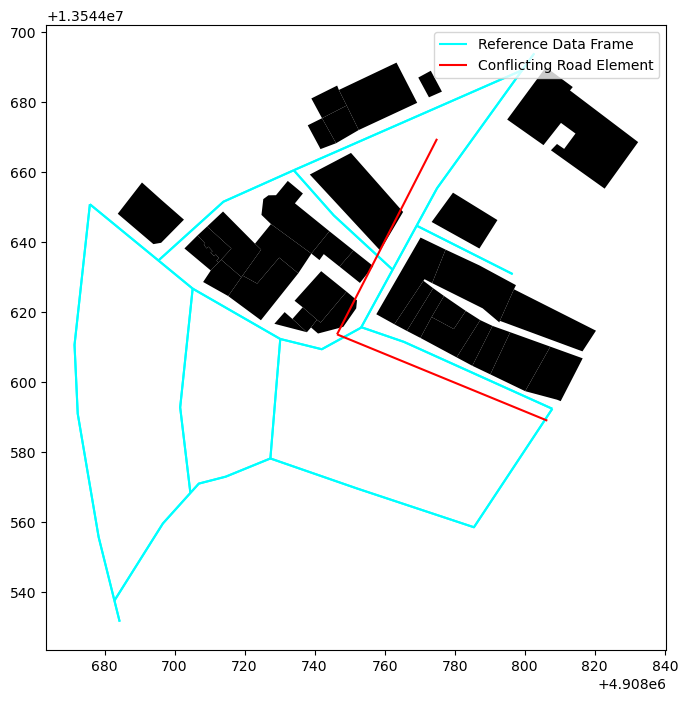

In [5]:
f, ax = plt.subplots(1)

referenced_data_frame.plot(ax=ax, color="cyan", label='Reference Data Frame')
trace_data_frame.plot(ax=ax,cmap=None, color="red", label='Conflicting Road Element')
obstacle_data_frame.plot(ax=ax, color="black", label='Building Footprint')

plt.legend()
plt.show()

### Initialize the grid for the area on which the conflict is to be resolved
the bounding box of the area can be extracted from [this](https://boundingbox.klokantech.com/) website and export it in json format

The bounding box can be of a city, or a smaller region, what ever the extent, it should occupy all the traces and obstacle to run

In [6]:
grid = PixelGrid.pixel_grid(
    resolution=1,
    grid_bounds=convert_and_get_extent(
        [
            [
                [2.13242075, 42.84341088],
                [2.23118924, 42.84341088],
                [2.23118924, 42.90975515],
                [2.13242075, 42.90975515],
                [2.13242075, 42.84341088],
            ]
        ],
        crs_to="epsg:26910",
    ),
)

### Add obstacle to the grid so the navigator is aware of which part of the grid is to avoid

In [7]:
grid.add_obstacle(obstacle_data_frame, extend_boundary_pixel=2)

### Generate Traces from dataframe and Initialize the Road Map to which th trace are to be matched

In [8]:
traces = traces_from_data_frame(trace_data_frame)
referenced_data = road_network_from_data_frame(referenced_data_frame)

### Initialize the Matcher with Refrence Data and The navigator to find path
observation_error is used to tell how off in *meters* the trace point are expected from the road network

In [9]:
matcher = Match(referenced_data, observation_error=30)
navigator = AStar()

>>Navigator Progress: Found GOAL (4150, 85), GOAL COUNT - 2/2COUNT - 2/33Traces - 2/2

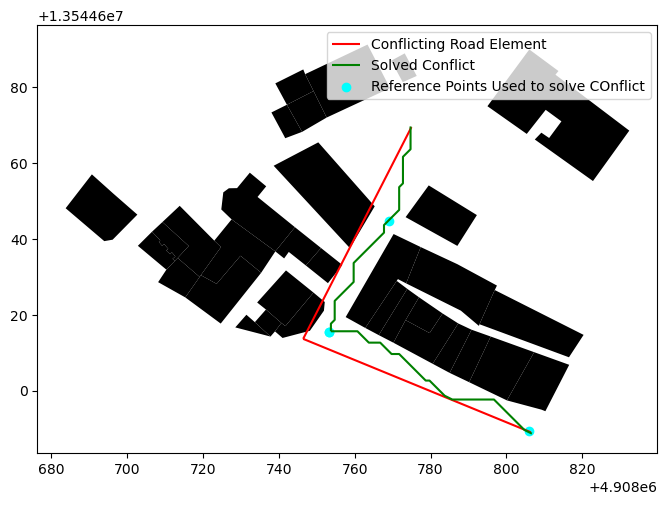

In [10]:
f, ax = plt.subplots(1)

solved_path_list = list()
reference_poi_list = list()

for trace_id, trace in traces.items():
    
    # REFRENCE POI WILL ACT AS INTERMEDIATE GOALS FOR THE NAVIGATOR TO REACH ITS FINAL GOAL
    _, _, reference_poi = matcher.match_trace(trace_id, trace)
    
    reference_poi_list.extend(reference_poi)
    
    # CONVERT COORDINATES TO TRACE
    intermediate_goals = [(point.x, point.y) for point in reference_poi]
    
    # ADD START ANF FINAL GOAL TO NEW TRACE
    intermediate_goals.insert(0, (trace[0].x, trace[0].y))
    intermediate_goals.insert(-1, (trace[-1].x, trace[-1].y))
    
    # INIATE NEW TRACE
    new_trace_coordinates = single_trace(intermediate_goals)

    
    # FIND THE PATH 
    solved_path = navigator.path_finder_from_trace(grid, new_trace_coordinates[0], search_space_threshold=5, area_simplify=1, epsilon=0)
    solved_path_list.append(LineString(solved_path))
    
# CREATE DATA FRAME FOR NEW FOUND PATH
solved_path_data_frame = gpd.GeoDataFrame(solved_path_list,
    columns=['LineString'], 
    geometry='LineString')

# CREATE DATA FRAME FOR REFERENCE POI
reference_poi_data_frame = gpd.GeoDataFrame(reference_poi_list,
    columns=['Points'], 
    geometry='Points')

# VISUALIZE THE PATH
obstacle_data_frame.plot(ax=ax, color="black", label='Building Footprint')
trace_data_frame.plot(ax=ax,cmap=None, color="red", label='Conflicting Road Element')
solved_path_data_frame.plot(ax=ax, cmap=None, color="green", label='Solved Conflict')
reference_poi_data_frame.plot(ax=ax, cmap=None, color="cyan", label='Reference Points Used to solve COnflict')

plt.legend()
plt.show()